# Corpus data demographics-based split

In this notebook, we analyze the demographics of Corpus NGT (CNGT). We get the demographics by scraping the demographic information from the [CNGT website](https://www.corpusngt.nl/). We have to clean this data before we can use it. Then, we are left with the demographics for each participant pair. It is not easy to figure out which participant is which, so the demographics stay paired. For instance, we may know that S00x and S00y are a pair and one is male and one female, but we cannot be sure if S00x is the female participant in that pair or if S00y is.

It is of course possible to simply assign all participants randomly to the train or test set. However, we wanted to make a semi-stratified split of the participants. This is done by first coding the participants by age, region and sex. We could only use a few categories to allow for some overlap between participants (if we use too many demographics we end up with too many unique combinations). The age is further binned into a binary decision, namely whether the average age of the paired participants is older than some threshold (for instance, 40 years). This is again done to make it possible to keep the number of combinations of values low.

Then, we make codes that represent their demographics. For instance, the code `A1MV` indicates that the participants are from Amsterdam (`A`), they are at least 40 years old (`1`) and the participants are male (`M` for Man) and female (`V` for Vrouw). We can then put them into the train set or into the validation/test set by stratifying. Note that the train set is made separately while the validation and test set are first grouped together, because we want to ensure that the train set contains different signers than the other sets. 

We have a few participants that could not be found with our webscrape but could be found when manually checking the Corpus website. The information about them was analyzed by us before we grouped them into the train or val/test set.

In [1]:
# Imports
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re
import numpy as np
import pympi
from sklearn.model_selection import train_test_split

import importlib

# Keep python tools up to date
from tools import tools, constants
importlib.reload(tools)
importlib.reload(constants)

# Import all functions from the tools
from tools.tools import*
from tools.constants import PATHS # Path constants

# Scraping Corpus NGT

In [2]:
%%time
# URLs to the corpus NGT website, specifically to the search section for (glossed) videos
# We also specify that they should be translated, which weirdly finds more videos than if we don't specify it.
first_url = "https://www.corpusngt.nl/keyword-search?keys=&op=Zoeken&geglost=1&vertaald=1" # page 1
url = "https://www.corpusngt.nl/keyword-search?page={}&keys=&op=Zoeken&geglost=1&vertaald=1" # pages from 2-27 (end)

# Start a session
# Initializing it here instead of in the for-loop speeds things up
request = requests.Session()
corpus_urls = []

# Request the webpage with the redirects to all the types
for i in range(1,28):
    if i == 1:
        page = request.get(first_url)
    else:
        page = request.get(url.format(i))
    soup = BeautifulSoup(page.content, "html.parser", parse_only=SoupStrainer('a')) # html.parser
    # Only filter for 'a' tags (which contain links/redirects)
    links = soup.findAll('a')
    # Links to corpus videos naturally include 'corpusvideo' in the url
    # We want to be left with only the url number for easier processing later on
    hrefs = [a['href'].replace('/corpusvideo/', '') for a in links if 'corpusvideo' in a['href']]
    hrefs = [h for h in hrefs if len(h) > 0]
    corpus_urls += hrefs

corpus_urls = list(set(corpus_urls))

print('Number of detected corpus NGT videos:', len(corpus_urls))

Number of detected corpus NGT videos: 381
CPU times: total: 828 ms
Wall time: 18.3 s


# Extract demographics

In [3]:
%%time
# Clean the scraped demographics
def prepare_bs_string(s):
    s = s.replace('\n', '')
    s = re.split('[<>]', s)
    s = [x for x in s if '/' not in x and '=' not in x and len(x) > 0]
    return s

base_url = 'https://www.corpusngt.nl/corpusvideo/{}'
video_demographics = {}

demographics_path = PATHS['cngt_demographics']

if os.path.exists(demographics_path):
    video_demographics = load_dict(demographics_path)
else:
    for i, corpus_url in enumerate(corpus_urls):
        print(i, end = '\r')
        video_url = base_url.format(corpus_url)
        try:
            page = request.get(video_url)
        except:
            continue
        soup = BeautifulSoup(page.content, "lxml") # html.parser
        p1 = prepare_bs_string(str(soup.find(class_="data_p1")))
        p2 = prepare_bs_string(str(soup.find(class_="data_p2")))
        video_id = prepare_bs_string(str(soup.find(class_="metadata")))[0]
        p = p1 + ['&&'] + p2
    #     print(p1, p2, video_id)
        video_demographics[video_id] = p
    store_dict(demographics_path, video_demographics)

CPU times: total: 0 ns
Wall time: 100 ms


In [4]:
path = PATHS['cngt_vids_and_eaf']
file_format = '.eaf'
cngt_files = find_files(path, file_format)

# Gives tuples like (video_id, signer_id)
signers_and_ids = [tuple(name.replace(file_format, '').split('_')[::-1]) for root, name in cngt_files]

signers_and_ids_dict = {}
for key, val in signers_and_ids:
    signers_and_ids_dict = append_to_list_in_dict(signers_and_ids_dict, key, val)

# Here, we want to make a dictionary of the format (key: participant_ids, val: demographics)
ids_demographics = {}
for key in signers_and_ids_dict:
    if key in video_demographics:
        p_str = '+'.join(signers_and_ids_dict[key])
        demographics = '||'.join(video_demographics[key])
        if '+' in p_str and '&&' in demographics:
            if not p_str in ids_demographics:
                ids_demographics = add_to_val_in_dict(ids_demographics, p_str, demographics, '')
            elif not demographics in ids_demographics[p_str]:
                ids_demographics = add_to_val_in_dict(ids_demographics, p_str, demographics, '')

In [5]:
def get_demographics(dict_):
    reg, age, sex, hand = [], [], [], []
    demos = [reg, age, sex, hand]
    for item in dict_.items():
        key, val = item
        for p in val.split('&&')[:2]: # Loop over the persons
            # Split on the demographic dividers ('Region: ...||Age: ...')
            p = [x for x in p.split('||') if len(x) > 0]
            # Get only the value (e.g if 'Region: Groningen') we only want to keep 'Groningen'
            p = [x.split(' ')[-1] for x in p]

            # Add to the corresponding demographic
            for i in range(len(demos)):
                demos[i] += [p[i]]
    return demos

demos = get_demographics(ids_demographics)

# Plotting demographics

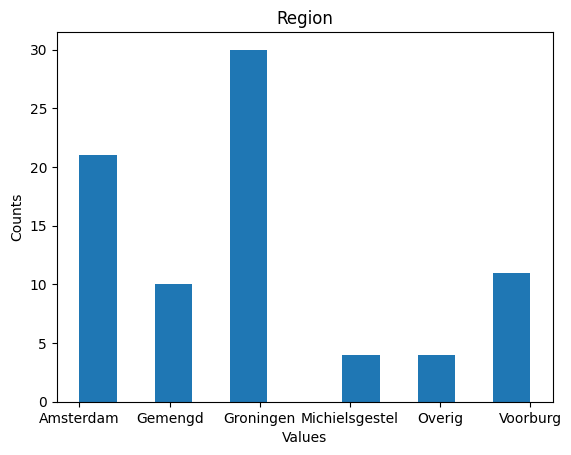

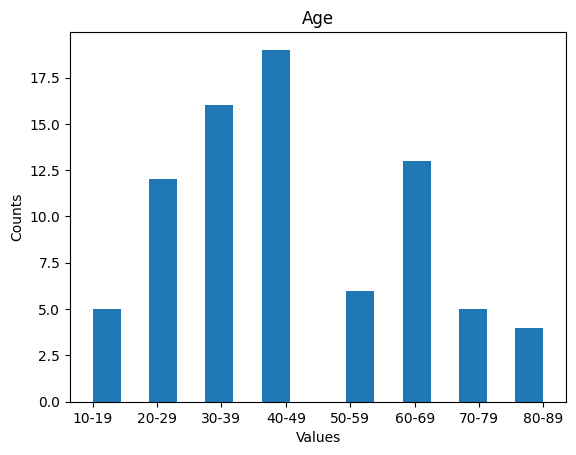

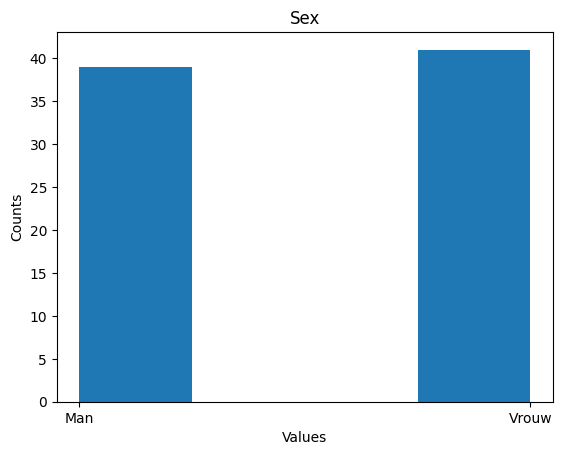

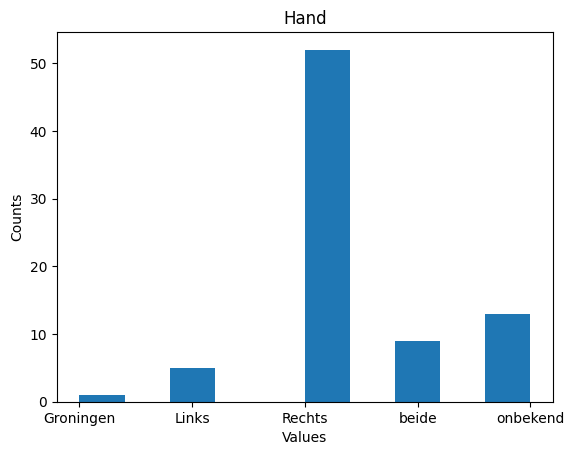

In [6]:
# Demographic distribution of the whole dataset
str_titles = ['Region', 'Age', 'Sex', 'Hand']
for i in range(len(demos)):
    demo = sorted(demos[i])
    str_title = str_titles[i]
    # For density distr. add: density = True, cumulative = True
    plt.hist(demo, bins = len(set(demo))*2)
    plt.title(str_title)
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.show()

# Coding demographics

In [7]:
# This function gets the first digit of the age
# Since all ages are above 10, '1' would indicate some age between 10-19 (first digit = 1)
# So a threshold of 4 means a threshold for age 40 (first digit = 4)
def bin_ages(age1_str, age2_str, threshold = 4):
    avg = (int(age1_str)+int(age2_str))/2
    age_bin = 1 if avg >= threshold else 0
    return age_bin

# Creating some easier-to-decipher codes of the demographics
# Where we basically take the first character/letter of each category
# And fuse them for the two participants in some manner
codes = []

# Loop over the different participant pairs
for v in list(ids_demographics.values()):
    # Get participant 1 and 2 and prepare their demo categories
    # By only keeping the first letter of each category entry
    p1, p2 = v.split('&&')[0], v.split('&&')[1]
    p1 = [x for x in p1.split('||')] # Split demos that are separated by ||
    p1 = [x.split(' ')[-1] for x in p1] # Get only the part after the colon
    p1 = [x[0] for x in p1 if len(x) > 0] # Keep only the first letter of the demographic
    
    p2 = [x for x in p2.split('||')]
    p2 = [x.split(' ')[-1] for x in p2]
    p2 = [x[0] for x in p2 if len(x) > 0][:4]
    
    # Fix an entry for part. 2 where they have 'Groningen' as their handedness
    if p2[-1] == 'G':
        p2[-1] = 'R'
    
    # Fusing the participant demographics
    p = []
    for i in range(len(p1)):
        # We discard the handedness because it makes stratifying even more difficult
        if p1[i] == p2[i] and i < 3:
            # If we're dealing with age, average the ages and bin them
            # To either < 40 or >= 40
            if i == 1:
                age_bin = bin_ages(p1[i],p2[i])
                p.append(str(age_bin))
            # If the value is the same for both participants (e.g. both from Amsterdam)
            # Then we keep only one of their values
            else: 
                p.append(p1[i])
        # If the values are different for both participants (e.g. one is male, one is female)
        # We store both, fusing them in alphabetical order (e.g. values G, A -> AG)
        else:
            if i == 1: # Average, then bin age like before
                age_bin = bin_ages(p1[i],p2[i])
                p.append(str(age_bin))
            elif i == 0 or i == 2:
                p.append(''.join(sorted([p1[i],p2[i]])))
    str_p = ''.join(p)
    codes.append(str_p)
print('Demographic codes:')
print(codes)

Demographic codes:
['A1MV', 'A1V', 'G0V', 'O0V', 'A0V', 'A0M', 'G0V', 'G1M', 'G1MV', 'G0MV', 'G0MV', 'G1MV', 'G0M', 'G0V', 'G0M', 'G1MV', 'G1V', 'G0MV', 'G1M', 'G1V', 'G1MV', 'M1MV', 'AV1M', 'V1M', 'A1V', 'G1M', 'V1V', 'M0V', 'O0V', 'G0M', 'A1MV', 'A0V', 'A0M', 'G0MV', 'V0M', 'G0M', 'A1V', 'A1M', 'V1V', 'V1M']


In [8]:
# We now still have some codes that don't occur more than once
# Which will stop us from using stratification later
# So, we group all codes which only occur once into a 'REST' category
counts = Counter(codes)
codes_2 = []
for i in range(len(codes)):
    code = codes[i]
    if counts[code] == 1:
        codes_2.append('REST')
    else:
        codes_2.append(code)
print('Demographic codes (putting single-occurrence codes as REST label)')
print(Counter(codes_2))

Demographic codes (putting single-occurrence codes as REST label)
Counter({'REST': 5, 'G1MV': 4, 'G0MV': 4, 'G0M': 4, 'A1V': 3, 'G0V': 3, 'G1M': 3, 'A1MV': 2, 'O0V': 2, 'A0V': 2, 'A0M': 2, 'G1V': 2, 'V1M': 2, 'V1V': 2})


# Split signers by demographics 

In train: ['S029+S030', 'S031+S032', 'S003+S004', 'S013+S014', 'S089+S090', 'S075+S076', 'S087+S088', 'S043+S044', 'S065+S066', 'S015+S016', 'S021+S022', 'S077+S078', 'S045+S075', 'S035+S036', 'S069+S070', 'S009+S010', 'S023+S024', 'S083+S084', 'S033+S034', 'S005+S006', 'S037+S038', 'S007+S008', 'S017+S018', 'S001+S002', 'S067+S068', 'S025+S026']
In test: ['S073+S074', 'S019+S020', 'S085+S086', 'S027+S028', 'S081+S082', 'S041+S042', 'S051+S052', 'S071+S072', 'S057+S058', 'S011+S012', 'S047+S048', 'S079+S080', 'S045+S046', 'S039+S040']


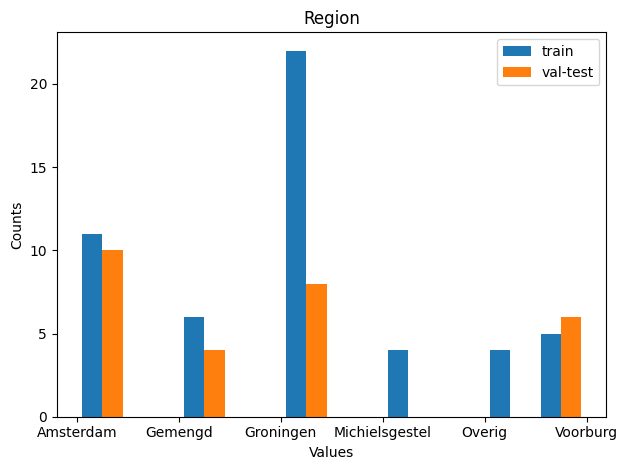

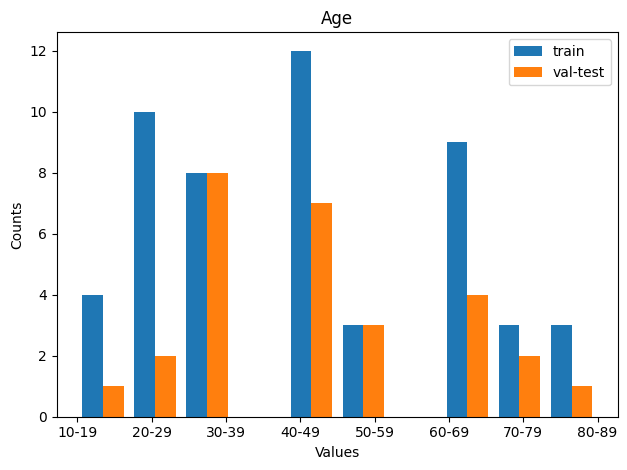

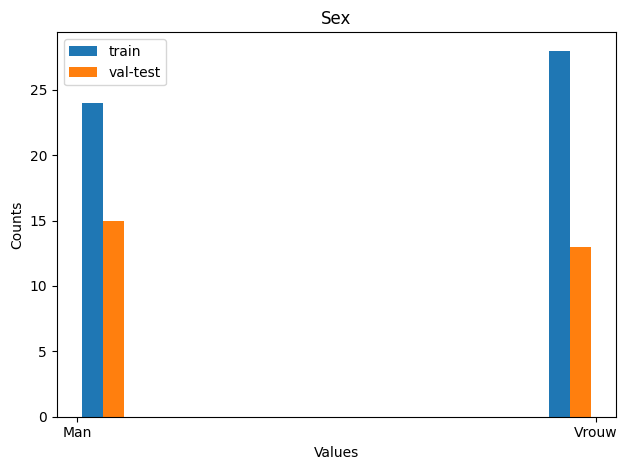

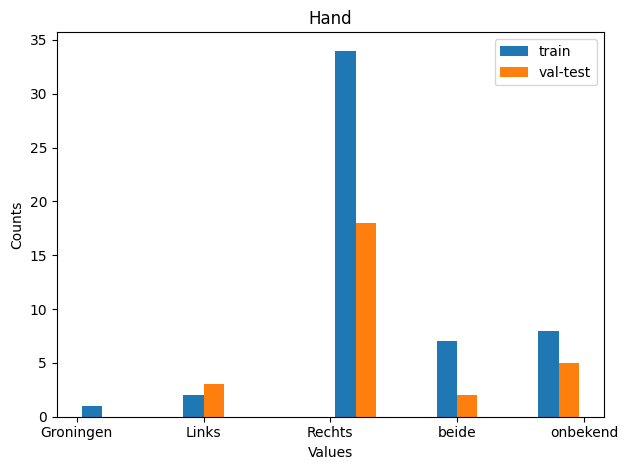

In [9]:
# Randomly sampling participants while trying to get decently even distributions 
# We achieve this using stratification of the binned demographics
# We choose a random state to make the results consistent every time
X_train, X_val_test, y_train, y_val_test = train_test_split(list(ids_demographics.items()), codes_2, test_size=0.33, 
                                                    stratify = codes_2, random_state=2)

train_group = dict(X_train)
val_test_group = dict(X_val_test)

demos_train = get_demographics(train_group)
demos_val_test = get_demographics(val_test_group)

print('In train:', list(train_group.keys()))
print('In test:', list(val_test_group.keys()))

for i in range(len(demos_train)):
    demo_train = sorted(demos_train[i])
    demo_val_test = sorted(demos_val_test[i])
    str_title = str_titles[i]
    plt.hist([demo_train, demo_val_test], label = ['train', 'val-test'])
    plt.title(str_title)
    plt.legend()
    plt.ylabel('Counts')
    plt.xlabel('Values')
    plt.tight_layout()
    plt.show()

In [10]:
# An example of what the demographics look like for a train set participant
key = list(train_group.keys())[0]
print(key, train_group[key])

S029+S030 Regio: Groningen||Leeftijd: 10-19||Geslacht: Man||Voorkeurshand: Rechts||&&||Regio: Groningen||Leeftijd: 10-19||Geslacht: Man||Voorkeurshand: onbekend


# Manually adding signers not found by scraping Corpus NGT

In [11]:
# Get only the IDs found through the demographics web scraping
id_pairs_partial = [tuple(sorted(x.split('+'))) for x in ids_demographics.keys()]

# Get all IDs that are in the Corpus video dataset
id_pairs_full = [tuple(sorted(x)) for x in signers_and_ids_dict.values() if len(x) > 1]

# Check (both ways) which id_pairs are missing from the corpus videos or from the website data
not_known_demos = list(set(id_pairs_full) - set(id_pairs_partial)) # Not found through webscrape
not_known_demos_2 = list(set(id_pairs_partial) - set(id_pairs_full)) # Not found in corpus

print('Not found with webscrape:', not_known_demos, '\nNot in corpus:', not_known_demos_2)

Not found with webscrape: [('S061', 'S062'), ('S091', 'S092'), ('S055', 'S056'), ('S063', 'S064'), ('S053', 'S054'), ('S059', 'S060'), ('S049', 'S050')] 
Not in corpus: []


In [12]:
# We manually add some of the participant IDs listed above to the train and val-test group
# While trying to keep the demographics balanced
def get_vid_ids_for_participants(groups):    
    ids = []
    
    for group in groups:
        group = group.split('+')
        for p in group:
            for key, vals in signers_and_ids_dict.items():
                for val in vals:
                    if val == p:
                        vid_id = '{}_{}'.format(key, val)
                        ids.append(vid_id)
    return ids

train_group_extended = list(train_group.keys()) + ['S091+S092', 'S063+S064', 'S062+S061', 'S060+S059', 'S049+S050']
val_test_group_extended = list(val_test_group.keys()) + ['S056+S055', 'S053+S054']

train_ids = get_vid_ids_for_participants(train_group_extended)
val_test_ids = get_vid_ids_for_participants(val_test_group_extended)

# Analyzing signer & video splits

In [13]:
num_train, num_val_test, num_total = len(train_ids), len(val_test_ids), len(train_ids) + len(val_test_ids)
percent_train, percent_val_test = round(100*num_train/num_total, 2), round(100*num_val_test/num_total, 2)
print('Num. of train videos: {} ({}%)\tval/test videos: {} ({}%)'.format(num_train, percent_train, 
                                                                         num_val_test, percent_val_test))

Num. of train videos: 636 (72.19%)	val/test videos: 245 (27.81%)


In [14]:
# Count the number of participants (each pair in group_extended contains 2 people so we multiply by 2)
num_ppl_train, num_ppl_val_test = 2*len(train_group_extended), 2*len(val_test_group_extended)
total_ppl = num_ppl_train + num_ppl_val_test
ppl_train_percent, ppl_val_test_percent =  round(100*num_ppl_train/total_ppl, 2), round(100*num_ppl_val_test/total_ppl, 2)
print('Num. of train participants: {} ({}%)\tval/test participants: {} ({}%)'.format(num_ppl_train, ppl_train_percent, 
                                                                                   num_ppl_val_test, ppl_val_test_percent))

Num. of train participants: 62 (65.96%)	val/test participants: 32 (34.04%)


In [15]:
# List some video IDs we could not find through the webscrape
targets = []
for tup in not_known_demos:
    for el in tup:
        for key, vals in signers_and_ids_dict.items():
            for val in vals:
                if val == el:
                    targets.append(key)
print('Video IDs not found through glossed-videos search on CNGT website:')
print(list(sorted(set(targets))))

Video IDs not found through glossed-videos search on CNGT website:
['CNGT1105', 'CNGT1129', 'CNGT1206', 'CNGT1261', 'CNGT1282', 'CNGT1283', 'CNGT1284', 'CNGT1285', 'CNGT1381', 'CNGT1415', 'CNGT1474', 'CNGT1491', 'CNGT1504', 'CNGT2332', 'CNGT2334', 'CNGT2341', 'CNGT2370', 'CNGT2375']


# Splitting val-test set into separate validation, test sets

In [16]:
# Split the videos in the val-test set into the validation and test set (using seeded randomness)
np.random.seed(123)

val_ids = np.random.choice(val_test_ids, int(len(val_test_ids)/2), replace = False).tolist()
test_ids = list(set(val_test_ids) - set(val_ids))
print('Validation videos:', len(val_ids), sorted(val_ids))
print('Test videos:', len(test_ids), sorted(test_ids))

id_split = {'Train': train_ids, 'Val': val_ids, 'Test': test_ids}
store_dict(PATHS['CNGT_split_ids'], id_split) # We store the split of the participants here

Validation videos: 122 ['CNGT0205_S011', 'CNGT0205_S012', 'CNGT0206_S012', 'CNGT0207_S011', 'CNGT0208_S012', 'CNGT0209_S011', 'CNGT0209_S012', 'CNGT0210_S011', 'CNGT0211_S012', 'CNGT0213_S012', 'CNGT0214_S011', 'CNGT0214_S012', 'CNGT0223_S011', 'CNGT0224_S012', 'CNGT0226_S011', 'CNGT0227_S011', 'CNGT0227_S012', 'CNGT0362_S020', 'CNGT0363_S019', 'CNGT0364_S020', 'CNGT0366_S020', 'CNGT0368_S020', 'CNGT0369_S020', 'CNGT0370_S019', 'CNGT0371_S019', 'CNGT0372_S019', 'CNGT0374_S020', 'CNGT0376_S019', 'CNGT0376_S020', 'CNGT0378_S019', 'CNGT0386_S019', 'CNGT0386_S020', 'CNGT0388_S019', 'CNGT0389_S019', 'CNGT0390_S019', 'CNGT0546_S028', 'CNGT0564_S027', 'CNGT0564_S028', 'CNGT0566_S027', 'CNGT0566_S028', 'CNGT0567_S028', 'CNGT0570_S028', 'CNGT0831_S039', 'CNGT0831_S040', 'CNGT0832_S039', 'CNGT0832_S040', 'CNGT0838_S040', 'CNGT0841_S040', 'CNGT0843_S040', 'CNGT0845_S040', 'CNGT0847_S039', 'CNGT0848_S039', 'CNGT0857_S040', 'CNGT0858_S040', 'CNGT0859_S039', 'CNGT0860_S039', 'CNGT0860_S040', 'CNGT08

In [17]:
# Store the test video IDs in the form 'Sxxx_CNGTyyyy'
test_vid_ids = ['_'.join(t.split('_')[::-1]) for t in test_ids]
val_vid_ids = ['_'.join(t.split('_')[::-1]) for t in val_ids]
np.save(PATHS['val_vid_ids'], np.array(val_vid_ids))
np.save(PATHS['test_vid_ids'], np.array(test_vid_ids))

In [18]:
# Get the test set annotations
anns_with_tiers = load_dict(PATHS['dataset_anns']) # Get video annotations
dataset_root = PATHS['cngt_vids_and_eaf'] # Root where all annotated .eaf sign files are 

# Getting the annotations and embeddings for test set videos
anns_test = {}
vid_i = 0
for k in anns_with_tiers:
    if not k.replace('.eaf', '') in test_vid_ids: # Only do this for test videos
        continue
    vid_i +=1 # Only increase counter if it's a test set video
    print('Getting anns for test set video {}/{}'.format(vid_i, len(test_vid_ids)), end = '\r')
    # Getting the landmarks
    eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, k))
    # Get the glosses and mouthings of the file
    anns_dict, mouthings_dict = get_gloss_vals(eaf_file)
    anns_dict = man_sim_and_hand_dist(anns_dict, manual_sim = False, two_hand_suffix = False)
    anns_test[k] = anns_dict # Store also the corresponding annotations in a dictionary

In [19]:
# Convert annotations timestamps from milliseconds to frames
anns_test = annotations_ms_to_frame(anns_test)
        
# Store the test set annotations in a dictionary
store_dict(PATHS['anns_test'], anns_test)